In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../../datasets/Movielens/'
data_dir = data_base_dir + 'serendipity-sac2018/'
data_dir2 = data_base_dir + 'ml-20m/'
output_dir = data_dir + 'output/'

# genome_scores = data_dir + 'genome_scores.csv'
genome_scores = data_dir + 'tag_genome.csv'
# genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
# ratings = data_dir + 'ratings.csv'
ratings = data_dir + 'training.csv'
# tags = data_dir + 'tags.csv'
answers = data_dir + 'answers.csv'
genre_binary_terms = output_dir + 'movie_genre_binary_term_vector_df_bz2'
movies_lemmatized = output_dir + 'movies_lemmatized_genome_vector_df_bz2'

answers_df = pd.read_csv(answers)

# data loading and preprocessing
genome_scores_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId',
                                                    values='relevance')
movies_with_genome = genome_scores_df.index.values
# movies_with_genome

movies_df = pd.read_csv(movies)
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df = movies_df[movies_df['movieId'].isin(movies_with_genome)]

all_movie_ids = movies_df['movieId'].unique()

ratings_df = pd.read_csv(ratings)
ratings_df = ratings_df[ratings_df['movieId'].isin(all_movie_ids)]
ratings_df = ratings_df.loc[:, ['userId', 'movieId', 'rating']]

all_user_ids = ratings_df['userId'].unique()

In [2]:
# TODO also filter users only inside recommendations or answers dataframe
count_df = answers_df.groupby('userId').count()
# count_df[count_df['movieId'] == 5]
all_answers_user_ids = count_df[count_df['movieId'] == 5].index.values

In [3]:
from sklearn.metrics import pairwise_distances, mean_absolute_error, mean_squared_error


class ContentBased_Recommender:
    def __init__(self, term_vector_df, ratings_df, K=5, metric='cosine', weighted=True):
        self.term_vector_df = term_vector_df
        self.K = K
        self.ratings_df = ratings_df
        self.weighted = weighted

        # preprocessing and other calculations
        self.term_vector_df.fillna(0, inplace=True)
        self.movie_movie_distances = term_vector_df

    def get_predicted_actual(self, user_id, candidate_movie_id, user_movies, K):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        # hide candidate movie from the user
        user_movies = np.setdiff1d(user_movies, candidate_movie_id)

        # load user rating for watched movies other than the candidate movie
        # user_ratings =
        users_all_ratings_df = ratings_df[ratings_df['userId'] == user_id]
        users_all_ratings_df = users_all_ratings_df[
            users_all_ratings_df['movieId'].isin(user_movies)]

        # load similarities to the candidate movie
        users_all_ratings_df['sim_candidate_movie'] = self.movie_movie_distances.loc[
            candidate_movie_id, users_all_ratings_df['movieId']].values

        predicted, actual = self.predict_ratings_and_get_predicted_actual(user_id,
                                                                          candidate_movie_id,
                                                                          users_all_ratings_df, K)

        return predicted, actual

    def predict_ratings_and_get_predicted_actual(self, user_id, candidate_movie_id,
                                                 users_all_ratings_df,
                                                 K):
        user_ratings = users_all_ratings_df['rating'].values[:K]
        similarities = users_all_ratings_df['sim_candidate_movie'].values[:K]

        predicted_rating = 0
        if self.weighted:
            # weighted average
            predicted_rating = np.sum(user_ratings * similarities) / np.sum(similarities)
        else:
            # non-weighted average
            predicted_rating = np.sum(user_ratings) / len(user_ratings)

        actual_rating = self.ratings_df[(self.ratings_df['userId'] == user_id) & (
                self.ratings_df['movieId'] == candidate_movie_id)]['rating'].values[0]

        if np.isnan(predicted_rating):
            #             predicted_rating = 0
            predicted_rating = actual_rating

        # mae = mean_absolute_error([actual_rating], [predicted_rating])
        # mse = mean_squared_error([actual_rating], [predicted_rating])

        return predicted_rating, actual_rating

    def get_mae_mse(self, user_id, user_movies, K):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
        predicted_rating_list = list()
        actual_rating_list = list()

        for candidate_movie_id in user_movies:
            predicted, actual = self.get_predicted_actual(user_id, candidate_movie_id, user_movies,
                                                          K)

            predicted_rating_list.append(predicted)
            actual_rating_list.append(actual)

        # calculate MSE, MAE here
        absolute = np.absolute(np.array(predicted_rating_list) - np.array(
            actual_rating_list))

        mae = np.sum(absolute) / len(predicted_rating_list)
        mse = np.sum(np.square(absolute)) / len(predicted_rating_list)

        return mae, mse

In [4]:
l1 = 'movies_lemmatized_threshold_'
l2 = '_float_movie_genomes_bz2'

# threshold_0.2_float_movie_genomes_bz2
l3 = 'threshold_'
l4 = '_float_movie_genomes_bz2'

thresholds = [0.25, 0.4, 0.7]
# thresholds = [0.25]

lemmatized_labels = [(l1 + str(x) + l2) for x in thresholds]
lemmatized_labels

full_labels = [(l3 + str(x) + l4) for x in thresholds]
full_labels

['threshold_0.25_float_movie_genomes_bz2',
 'threshold_0.4_float_movie_genomes_bz2',
 'threshold_0.7_float_movie_genomes_bz2']

In [5]:
# loading all required data
# user_full_genome_terms_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_bz2',
#                                            compression='bz2')
# user_full_genome_terms_gzip_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_gzip',
#                                                 compression='bz2')

lemmatized_thresholded_dfs = list()
full_thresholded_dfs = list()

for i, t in enumerate(thresholds):
    lemmatized_thresholded_dfs.append(
        pd.read_pickle(output_dir + lemmatized_labels[i], compression='bz2'))
    full_thresholded_dfs.append(
        pd.read_pickle(output_dir + full_labels[i], compression='bz2'))

In [37]:
# load term vectors
genre_binary_terms_df = pd.read_pickle(genre_binary_terms, compression='bz2')
movies_lemmatized_df = pd.read_pickle(movies_lemmatized, compression='bz2')

lemmatized_recommenders = list()
full_recommenders = list()

for i, t in enumerate(thresholds):
    full_recommenders.append(
        ContentBased_Recommender(full_thresholded_dfs[i], ratings_df, weighted=True))
    lemmatized_recommenders.append(
        ContentBased_Recommender(lemmatized_thresholded_dfs[i], ratings_df,
                                 weighted=True))

In [39]:
genre_recommender = ContentBased_Recommender(genre_binary_terms_df, ratings_df,
                                             metric='jaccard', weighted=True)
genome_full_recommender = ContentBased_Recommender(genome_scores_df, ratings_df,
                                                   metric='cosine', weighted=True)
genome_lemmatized_recommender = ContentBased_Recommender(movies_lemmatized_df, ratings_df,
                                                             metric='cosine', weighted=True)

class RunPredictions:

    def run(this, K, ug, users_ndarray, start_range=0, end_range=None):
        print('running for K: %d' % K)
        if end_range is None:
            end_range = len(users_ndarray)

        # mae lists
        genre_mae_list = list()
        genome_full_mae_list = list()
        genome_lemmatized_mae_list = list()

        lemmatized_mae_list = list()
        full_mae_list = list()

        # mse lists
        genre_mse_list = list()
        genome_full_mse_list = list()
        genome_lemmatized_mse_list = list()

        lemmatized_mse_list = list()
        full_mse_list = list()

        for user_id in users_ndarray[start_range:end_range]:
            start_time = time()
#             update_global_uid(user_id)
            print('user_id', user_id)

            # movies watched by user
            user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

            if len(user_movies) <= 1:
                continue

            mae, mse = genre_recommender.get_mae_mse(user_id, user_movies, K)
            genre_mae_list.append(mae)
            genre_mse_list.append(mse)

            mae, mse = genome_full_recommender.get_mae_mse(user_id, user_movies, K)
            genome_full_mae_list.append(mae)
            genome_full_mse_list.append(mse)

            mae, mse = genome_lemmatized_recommender.get_mae_mse(user_id, user_movies, K)
            genome_lemmatized_mae_list.append(mae)
            genome_lemmatized_mse_list.append(mse)

            for i, t in enumerate(thresholds):
                mae, mse = full_recommenders[i].get_mae_mse(user_id, user_movies, K)
                full_mae_list.append(mae)
                full_mse_list.append(mse)

                mae, mse = lemmatized_recommenders[i].get_mae_mse(user_id, user_movies, K)
                lemmatized_mae_list.append(mae)
                lemmatized_mse_list.append(mse)

            finish_time = time() - start_time
            print("Total time taken for this user: %f seconds" % finish_time)

        mae_df = pd.DataFrame()
        mae_df['genre_MAE'] = genre_mae_list
        mae_df['genome_full_MAE'] = genome_full_mae_list
        mae_df['genome_lemmatized_MAE'] = genome_lemmatized_mae_list

        mse_df = pd.DataFrame()
        mse_df['genre_MSE'] = genre_mse_list
        mse_df['genome_full_MSE'] = genome_full_mse_list
        mse_df['genome_lemmatized_MSE'] = genome_lemmatized_mse_list

        for i, t in enumerate(thresholds):
            mae_df[full_labels[i] + '_MAE'] = full_mae_list[i]
            mse_df[full_labels[i] + '_MSE'] = full_mse_list[i]

            mae_df[lemmatized_labels[i] + '_MAE'] = lemmatized_mae_list[i]
            mse_df[lemmatized_labels[i] + '_MSE'] = lemmatized_mse_list[i]

        mae_df.median().plot(kind='barh',
                             title='K=' + str(K) + ', median MAE, ' + ug, figsize=(20, 5))
        # figname = output_dir + 'K=' + str(K) + ', median MAE, ' + ug
        figname = 'K=' + str(K) + ', median MAE, ' + ug
        plt.tight_layout()
        plt.show()
#         plt.savefig(fname=figname, dpi=150)
        mae_df.to_pickle(figname + '_df')

        # plt.clf()
        mse_df.median().plot(kind='barh',
                             title='K=' + str(K) + ', median MSE, ' + ug, figsize=(20, 5))

        # figname = output_dir + 'K=' + str(K) + ', median MSE, ' + ug
        figname = 'K=' + str(K) + ', median MSE, ' + ug
        plt.tight_layout()
        plt.show()
#         plt.savefig(fname=figname, dpi=150)

        mse_df.to_pickle(figname + '_df')
        print("")
        
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

def run_parallel_for_users_range(ug, users_ndarray, K_ranges, start_range, end_range):
#     with ProcessPoolExecutor(max_workers=4) as executor:
#         # p_list = list()
#         for index, K in enumerate(K_ranges):
#             rp = RunPredictions()
#             executor.submit(rp.run, K, ug, users_ndarray, start_range, end_range)

    K = 10
    rp = RunPredictions()
    rp.run(K, ug, users_ndarray, start_range, end_range)
    print("main thread")

In [40]:
K_ranges = [10, 25]
start_range = 0
end_range = len(all_answers_user_ids)
# end_range = 5
ug = 'All_serendipity_answer_users'
n_k_ranges = 2

run_parallel_for_users_range(ug, all_answers_user_ids, K_ranges[:n_k_ranges], start_range, end_range)

running for K: 10
user_id 100200


KeyError: "None of [Int64Index([788,  21, 223, 586, 500, 595, 317, 250, 587,  88, 454, 837, 150,\n            588, 733, 231, 296, 344, 333, 364, 608,   2, 736, 765, 647, 673,\n             44, 802, 780, 145, 589, 216, 104, 153, 367, 784, 377,  47, 527,\n            318,   1, 480, 593, 356],\n           dtype='int64', name='tagId')] are in the [index]"

In [27]:
# import matplotlib.pyplot as plt
# from time import time
# import warnings

# warnings.filterwarnings('ignore')

# labels = ['genre_binary', 'genome_full', 'genome_lemmatized']
# all_movie_ids = genre_binary_terms_df.index.values


# def run(index, K, start_range, end_range):
#     #     for index, K in enumerate(K_ranges):
#     genre_recommender = ContentBased_Recommender(genre_binary_terms_df, ratings_df, K,
#                                                  metric='jaccard', weighted=True)
#     genome_full_recommender = ContentBased_Recommender(genome_scores_df, ratings_df, K,
#                                                        metric='cosine', weighted=True)
#     genome_lemmatized_recommender = ContentBased_Recommender(movies_lemmatized_df, ratings_df, K,
#                                                              metric='cosine', weighted=True)

#     lemmatized_recommenders = list()
#     full_recommenders = list()

#     for i, t in enumerate(thresholds):
#         full_recommenders.append(
#             ContentBased_Recommender(full_thresholded_dfs[i], ratings_df, K, weighted=True))
#         lemmatized_recommenders.append(
#             ContentBased_Recommender(lemmatized_thresholded_dfs[i], ratings_df, K, weighted=True))

#     # mae lists
#     genre_mae_list = list()
#     genome_full_mae_list = list()
#     genome_lemmatized_mae_list = list()

#     lemmatized_mae_list = list()
#     full_mae_list = list()

#     # mse lists
#     genre_mse_list = list()
#     genome_full_mse_list = list()
#     genome_lemmatized_mse_list = list()

#     lemmatized_mse_list = list()
#     full_mse_list = list()

#     for user_id in all_answers_user_ids[start_range:end_range]:
#         start_time = time()
#         print('user_id', user_id)

#         # movies watched by user
#         user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

#         if len(user_movies) <= 1:
#             continue

#         mae, mse = genre_recommender.get_mae_mse(user_id, user_movies, K)
#         genre_mae_list.append(mae)
#         genre_mse_list.append(mse)

#         mae, mse = genome_full_recommender.get_mae_mse(user_id, user_movies, K)
#         genome_full_mae_list.append(mae)
#         genome_full_mse_list.append(mse)

#         mae, mse = genome_lemmatized_recommender.get_mae_mse(user_id, user_movies, K)
#         genome_lemmatized_mae_list.append(mae)
#         genome_lemmatized_mse_list.append(mse)

#         for i, t in enumerate(thresholds):
#             mae, mse = full_recommenders[i].get_mae_mse(user_id, user_movies, K)
#             full_mae_list.append(mae)
#             full_mse_list.append(mse)

#             mae, mse = lemmatized_recommenders[i].get_mae_mse(user_id, user_movies, K)
#             lemmatized_mae_list.append(mae)
#             lemmatized_mse_list.append(mse)

#         finish_time = time() - start_time
#         print("Total time taken for this user: %f seconds" % finish_time)

#     mae_df = pd.DataFrame()
#     mae_df['genre_MAE'] = genre_mae_list
#     mae_df['genome_full_MAE'] = genome_full_mae_list
#     mae_df['genome_lemmatized_MAE'] = genome_lemmatized_mae_list

#     mse_df = pd.DataFrame()
#     mse_df['genre_MSE'] = genre_mse_list
#     mse_df['genome_full_MSE'] = genome_full_mse_list
#     mse_df['genome_lemmatized_MSE'] = genome_lemmatized_mse_list

#     for i, t in enumerate(thresholds):
#         mae_df[full_labels[i] + '_MAE'] = full_mae_list[i]
#         mse_df[full_labels[i] + '_MSE'] = full_mse_list[i]

#         mae_df[lemmatized_labels[i] + '_MAE'] = lemmatized_mae_list[i]
#         mse_df[lemmatized_labels[i] + '_MSE'] = lemmatized_mse_list[i]

#     print("")
#     mae_df.median().plot(kind='barh',
#                          title='K=' + str(K) + ', avg MAE across all users, for all movies')
#     plt.show()
#     mse_df.median().plot(kind='barh',
#                          title='K=' + str(K) + ', avg MSE across all users, for all movies')
#     plt.show()


# import multiprocessing as mp
# import matplotlib.pyplot as plt


In [56]:
user_id = 206808
print('Progress %.2f%%' % ((np.where(all_answers_user_ids == user_id)[0][0]/(all_answers_user_ids.size - 1)) * 100))

Progress 100.00%


main process
user_id 101049
user_id 101049
Total time taken for this user: 6.135335 seconds
user_id 101170
Total time taken for this user: 6.253494 seconds
user_id 101170
Total time taken for this user: 54.449054 seconds
user_id 101263
Total time taken for this user: 54.813672 seconds
user_id 101263
Total time taken for this user: 14.066595 seconds
user_id 101579
Total time taken for this user: 14.253590 seconds
user_id 101579
Total time taken for this user: 12.105224 seconds
user_id 101721
Total time taken for this user: 12.129432 seconds
user_id 101721
Total time taken for this user: 18.849368 seconds
user_id 101743
Total time taken for this user: 19.160431 seconds
user_id 101743
Total time taken for this user: 22.739281 seconds



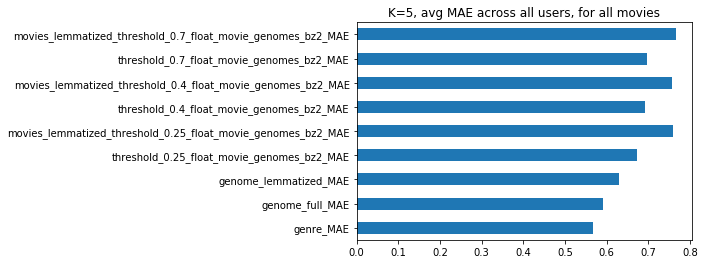

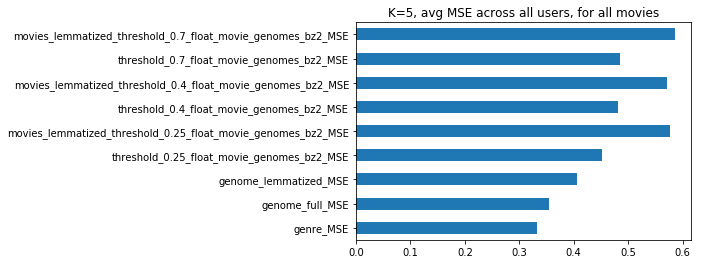

Total time taken for this user: 22.444452 seconds



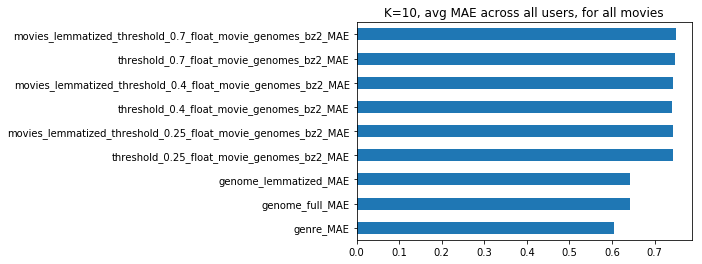

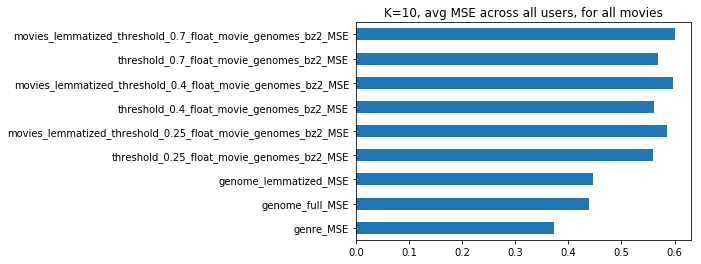

In [15]:
# K_ranges = [5, 10]
# start_range = 5
# # end_range = len(all_answers_user_ids)
# end_range = 11
# run_parallel_for_users_range(start_range, end_range, K_ranges)